In [ ]:
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
import PIL.Image as Image
from glob import glob

In [ ]:
!wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-train-data.zip #training data


--2024-05-10 12:30:52--  https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-train-data.zip
Resolving xeek-public-287031953319-eb80.s3.amazonaws.com (xeek-public-287031953319-eb80.s3.amazonaws.com)... 3.5.25.189, 52.217.235.161, 3.5.19.125, ...
Connecting to xeek-public-287031953319-eb80.s3.amazonaws.com (xeek-public-287031953319-eb80.s3.amazonaws.com)|3.5.25.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26029613 (25M) [application/zip]
Saving to: ‘stranger-sections-2-train-data.zip’

stranger-sections-2 100%[===================>]  24.82M  54.7MB/s    in 0.5s    

2024-05-10 12:30:53 (54.7 MB/s) - ‘stranger-sections-2-train-data.zip’ saved [26029613/26029613]



In [ ]:
!pip install patool
import patoolib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 934.2 kB/s eta 0:00:00


In [ ]:
patoolib.extract_archive('/content/stranger-sections-2-train-data.zip')

INFO patool: Extracting /content/stranger-sections-2-train-data.zip ...
INFO:patool:Extracting /content/stranger-sections-2-train-data.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_w_wjj5vm -- /content/stranger-sections-2-train-data.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_w_wjj5vm -- /content/stranger-sections-2-train-data.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/stranger-sections-2-train-data.zip extracted to `stranger-sections-2-train-data' (multiple files in root).
INFO:patool:... /content/stranger-sections-2-train-data.zip extracted to `stranger-sections-2-train-data' (multiple files in root).


'stranger-sections-2-train-data'

In [ ]:
!pip install segmenteverygrain
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob
import segmenteverygrain as seg
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.5 MB/s eta 0:00:00


In [ ]:
from importlib import reload
reload(seg)

<module 'segmenteverygrain' from '/usr/local/lib/python3.10/dist-packages/segmenteverygrain/__init__.py'>

In [ ]:
!which jupyter

/usr/local/bin/jupyter


import shutil
shutil.rmtree("/content/image_patches")

In [ ]:
images = sorted(glob('/content/stranger-sections-2-train-data/image/*'))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)

    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])


    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = 'im%03d.png'%(start_no + i)

        im = Image.fromarray(im.astype(np.uint8))
        im.save(os.path.join("/content/image_patches",imname))

    start_no = start_no + patches.shape[0]

100%|██████████| 85/85 [03:16<00:00,  2.31s/it]


In [ ]:
labels = sorted(glob('/content/stranger-sections-2-train-data/label/*'))
start_no = 0
for image2 in tqdm(labels):
    array = np.load(image2)

    # Load the large image
    # large_image = tf.keras.preprocessing.image.load_img(image)
    # large_image = image
    # Convert the image to a tensor
    # large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = tf.convert_to_tensor(array*85)

# Check the type and shape of the tensor
    # print("Type of the tensor:", type(large_image))
    # print("Shape of the tensor:", large_image.shape)

    large_image = large_image[:,:,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname =  'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(os.path.join("/content/label_patches",imname))

    start_no = start_no + patches.shape[0]

100%|██████████| 85/85 [00:15<00:00,  5.62it/s]


In [ ]:
image_files = sorted(glob(os.path.join('/content/image_patches','*.png')))
mask_files = sorted(glob(os.path.join('/content/label_patches', '*.png')))
print(len(image_files))
print(len(mask_files))
batch_size = 32
shuffle_buffer_size = 1000


# First, split the data into training + validation and test sets
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    image_files,
    mask_files,
    test_size=0.15,  # 15% of the data for testing
    random_state=42
)
# Then split the training + validation set into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images,
    train_val_masks,
    test_size=0.25,  # 25% of the remaining data for validation
    random_state=42
)

# use this if you do not want to do image augmentation:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
# use this if you want to do image augmentation:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks, tf.Variable([True] * len(train_images), dtype=tf.bool)))
train_dataset = train_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

5355
5355


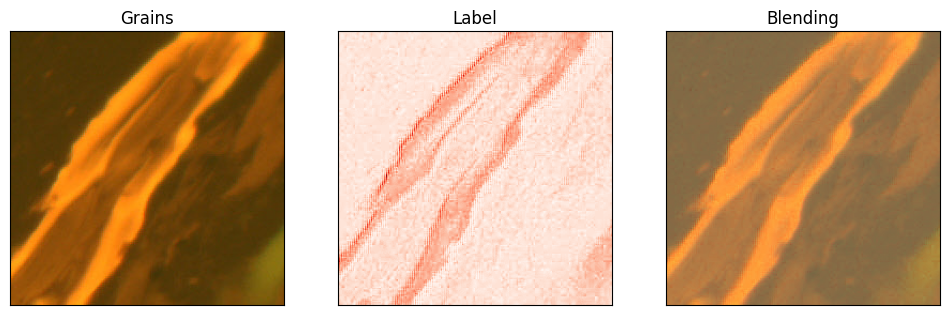

In [ ]:
fname = train_images[1304]
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # need to convert from BGR to RGB
mask = cv2.imread(fname.replace('images', 'labels'))
seg.plot_images_and_labels(img, mask)

In [ ]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [ ]:
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
107/107 [==============================] - 95s 546ms/step - loss: 0.3972 - accuracy: 0.7950 - val_loss: 0.2901 - val_accuracy: 1.0000
Epoch 2/5
107/107 [==============================] - 55s 422ms/step - loss: 0.3281 - accuracy: 0.9104 - val_loss: 0.2918 - val_accuracy: 0.9955
Epoch 3/5
107/107 [==============================] - 52s 423ms/step - loss: 0.3089 - accuracy: 0.9414 - val_loss: 0.2936 - val_accuracy: 0.9920
Epoch 4/5
107/107 [==============================] - 53s 426ms/step - loss: 0.3010 - accuracy: 0.9587 - val_loss: 0.2924 - val_accuracy: 0.9957
Epoch 5/5
107/107 [==============================] - 52s 421ms/step - loss: 0.2977 - accuracy: 0.9639 - val_loss: 0.2918 - val_accuracy: 0.9960


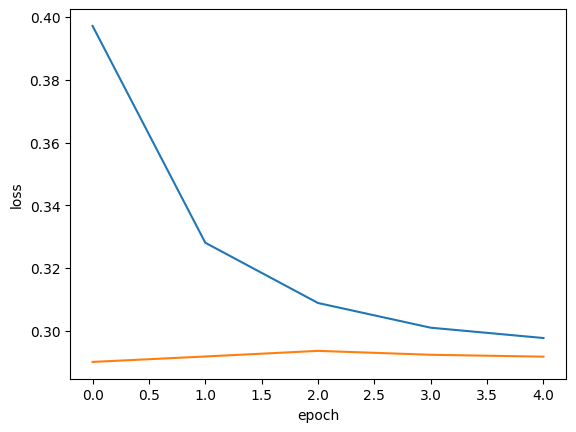

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss');

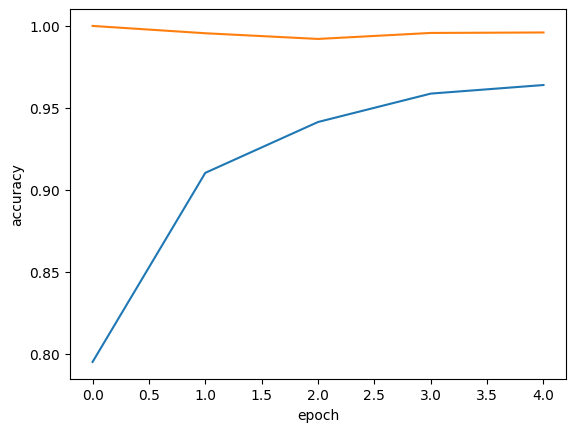

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy');


In [ ]:
model.evaluate(test_dataset)

26/26 [==============================] - 7s 171ms/step - loss: 0.2883 - accuracy: 0.9960


[0.2882803678512573, 0.9959926605224609]

In [ ]:
model.save_weights('./checkpoints/seg_model')

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!{sys.executable} -m pip install segmenteverygrain
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-31cxfb6v
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-31cxfb6v
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-05-10 12:45:53--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   964KB/s    in 2m 32s  

2024-05-1

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from tqdm import trange

In [ ]:
import tensorflow as tf
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.load_weights('./checkpoints/seg_model')

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00


In [ ]:
%matplotlib ipympl

In [ ]:
fname = '/content/seperate_test_data/1knjzt.JPG'

big_im = np.array(load_img(fname))
big_im_pred = seg.predict_big_image(big_im, model, I=256)
# decreasing the 'dbs_max_dist' parameter results in more SAM prompts (and longer processing times):
labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=10.0)
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels, min_area=50.0)

 43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

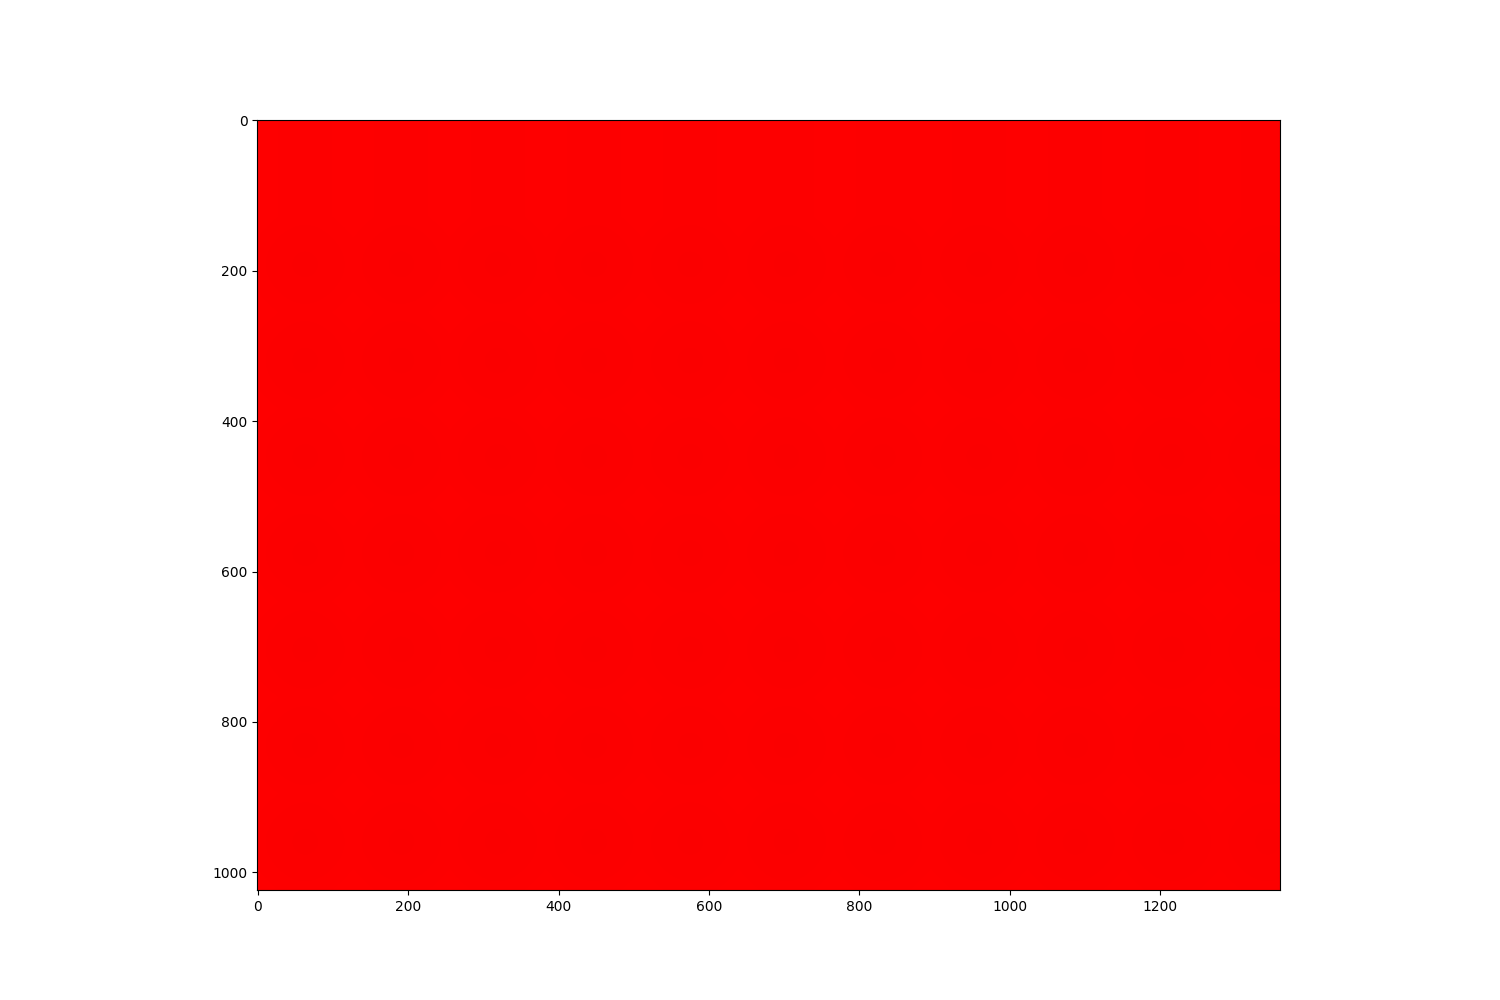

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
# ax.imshow(big_im)
ax.imshow(big_im_pred)
# seg.plot_image_w_colorful_grains(big_im, all_grains, ax, cmap='Paired')
# seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)